In [1]:
import pandas as pd
import numpy as np
from shapely import geometry
from shapely.ops import cascaded_union
import os, glob

In [5]:
# specify folder with contour files:
data_folder = r'E:\Data\20240723-F373-9_MF4dna-mCherry'
contour_filename_list = [_f for _f in glob.glob(data_folder+os.sep+'*') if 'contour_' in _f and 'position' not in _f]
contour_filename_list = [_f for _f in sorted(contour_filename_list, 
                                             key=lambda v:int(os.path.basename(v).split('.')[0].split('contour_')[1]))]
print(contour_filename_list)

['E:\\Data\\20240723-F373-9_MF4dna-mCherry\\contour_0.txt', 'E:\\Data\\20240723-F373-9_MF4dna-mCherry\\contour_1.txt']


In [6]:
print(f"Get position file for {len(contour_filename_list)} contours.")
# merged positions for all positions
postions_all = []

for contour_filename in contour_filename_list:
    # read contour coords
    points = pd.read_csv(contour_filename, header=None, sep=',')
    points.columns=['X', 'Y']
    # convert to polygon
    
    grid_size = int(2304 * 0.107 * 0.90) # um
    print(grid_size)

    tissue = geometry.Polygon(points.values)
    grid_center = np.round(np.array(tissue.centroid.coords)[0], 1)
    grid_inds = [np.arange(np.floor( (np.min(points['X'])-grid_center[0])/grid_size ), 
                  np.ceil( (max(points['X'])-grid_center[0])/grid_size )+1 ),
         np.arange(np.floor( (np.min(points['Y'])-grid_center[1])/grid_size ), 
                  np.ceil( (max(points['Y'])-grid_center[1])/grid_size )+1 ),
        ]
            
    grids = np.array(np.meshgrid(*grid_inds))#.reshape(len(grid_inds),-1).transpose()
    # generate tiles in snake style

    sorted_grids = []
    for _iy in np.arange(grids.shape[-1]):
        _line_grids = grids[:,:,_iy]
        if _iy % 2 == 0:
            sorted_grids.append(_line_grids)
        else:
            sorted_grids.append(np.fliplr(_line_grids))
    
    grids = np.concatenate(sorted_grids, axis=1).transpose()
    
    # get to positions coord inside the grid      
    positions = []

    for _i, _grid in enumerate(grids):
        _grid_position = _grid * grid_size + grid_center
        #print(_grid_position)
        # get each grid point
        _grid_point = geometry.Point(_grid_position)
        _fov_shape = geometry.Polygon([
                _grid_position + [-grid_size/2, -grid_size/2], 
                _grid_position + [grid_size/2, -grid_size/2], 
                _grid_position + [grid_size/2, grid_size/2], 
                _grid_position + [-grid_size/2, grid_size/2], 
            ])
        # calculate intersect
        _intersect = _fov_shape.intersection(tissue)
        if _intersect.area > 0:
            positions.append(_grid_position)
            postions_all.append(_grid_position)
    positions = np.array(positions)
    #print(np.shape(positions))
    
    
    overwrite = False
    save_filename = contour_filename.replace('.txt', '_positions.txt')

    if os.path.exists(save_filename) and not overwrite:
        print(f"file: {save_filename} already exist, skip!")
    else:
        print(f"save {len(positions)} coordinates into file: {save_filename}")
        np.savetxt(save_filename, np.round(positions,2), delimiter=',', fmt='%.2f')

    
    
postions_all =np.array(postions_all)
merged_save_filename = os.path.join(data_folder, r'positions_all.txt')
exp_date = data_folder.split('\\')[-1].split('-')[0]
analysis_save_filename = os.path.join(data_folder, f'{exp_date}_positions_all.txt')

if os.path.exists(merged_save_filename) and not overwrite:
    print(f"file: {merged_save_filename} already exist, skip!")
else:
    print(f"Save {len(postions_all)} coordinates into the merged file: {merged_save_filename}")
    np.savetxt(merged_save_filename, np.round(postions_all,2), delimiter=',', fmt='%.2f')
    #np.savetxt(analysis_save_filename, np.round(postions_all,2), delimiter=',', fmt='%.2f')
    



Get position file for 2 contours.
221
save 125 coordinates into file: E:\Data\20240723-F373-9_MF4dna-mCherry\contour_0_positions.txt
221
save 49 coordinates into file: E:\Data\20240723-F373-9_MF4dna-mCherry\contour_1_positions.txt
Save 174 coordinates into the merged file: E:\Data\20240723-F373-9_MF4dna-mCherry\positions_all.txt


## Plot

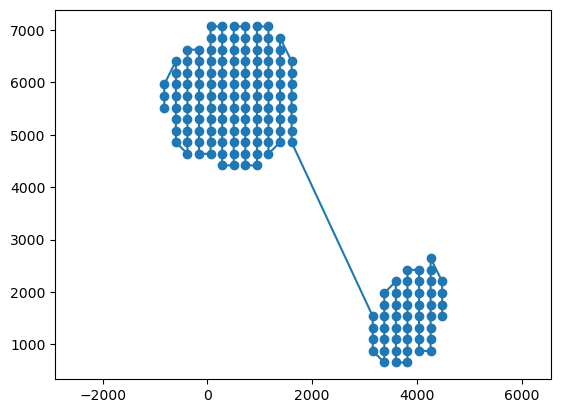

In [7]:
# check moving directions:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(postions_all[:,0],postions_all[:,1], 'o-',)
plt.axis('equal')
plt.show()